In [17]:
import numpy as np
import scipy
from scipy.misc import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import filters
from sklearn.ensemble import RandomForestClassifier
import h5py
import skimage.feature

# Load data

In [18]:
hdf5_path = '/media/sf_training/hdf5/'
filename = 'dataset_augmented_50.hdf5'
#filename = 'test.hdf5'

In [19]:
dataset = h5py.File(hdf5_path + filename, 'r')

In [20]:
print(dataset['train_label'].shape)

(383, 200, 200, 3)


### Make sure they look fine

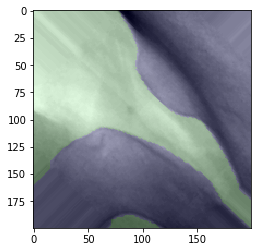

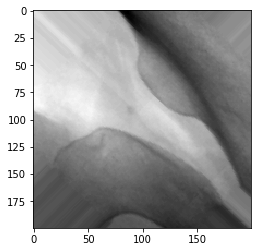

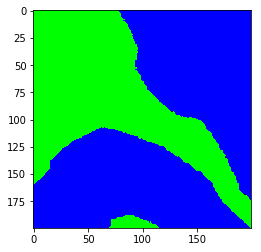

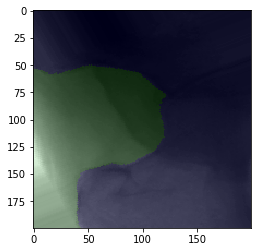

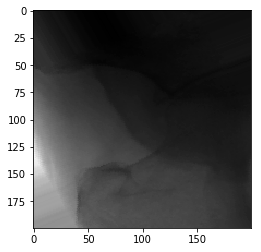

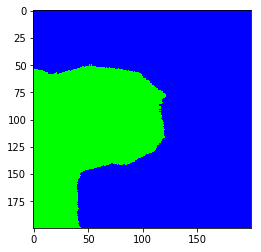

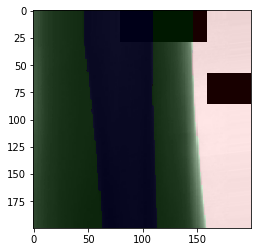

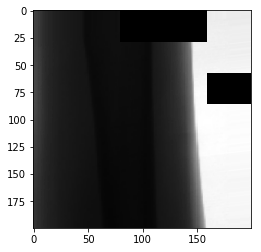

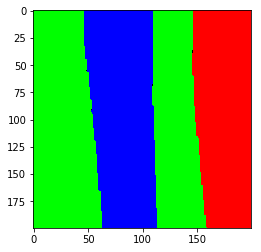

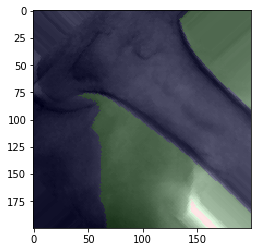

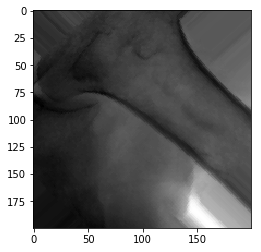

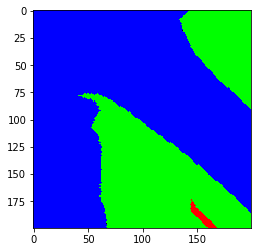

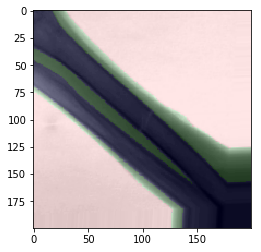

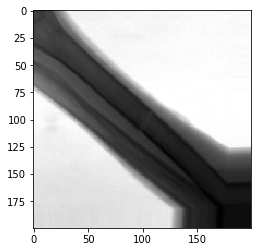

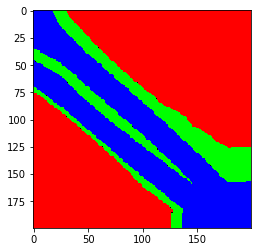

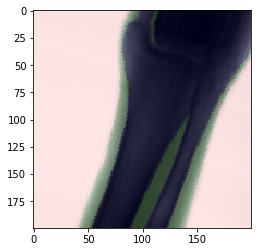

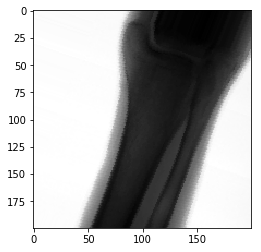

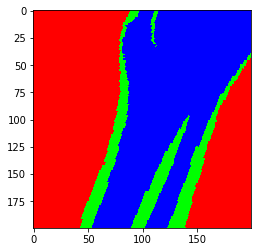

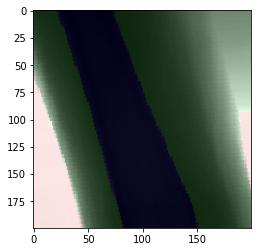

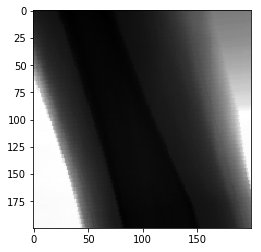

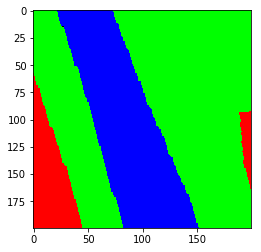

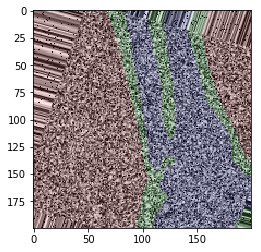

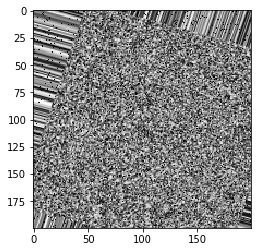

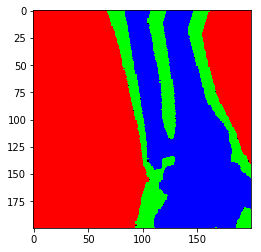

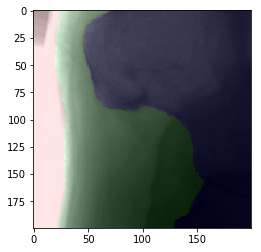

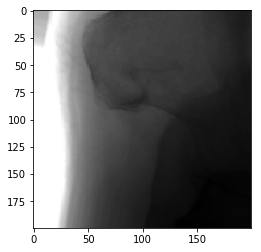

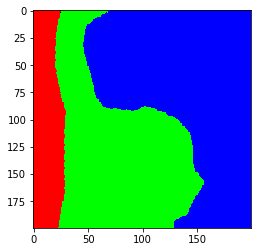

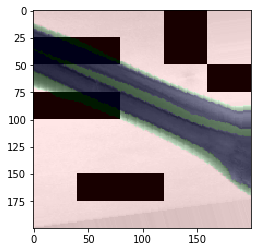

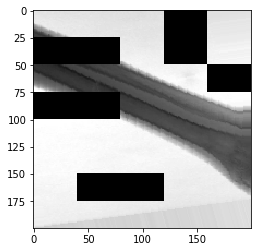

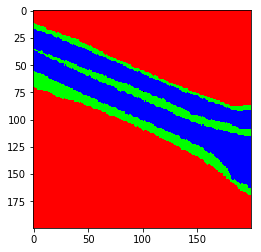

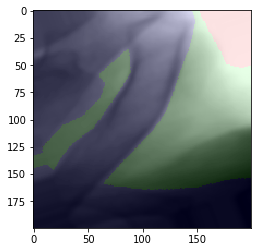

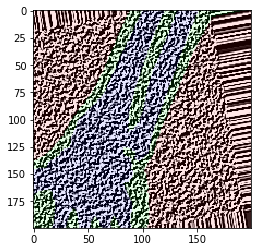

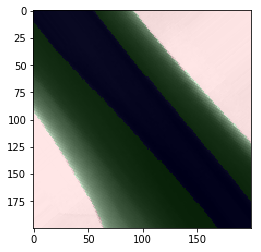

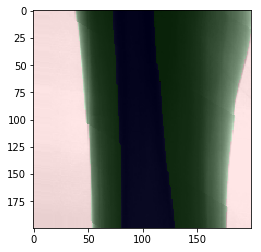

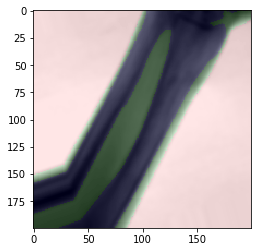

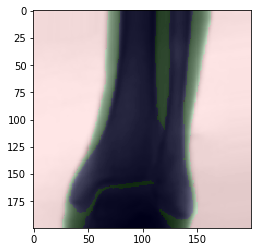

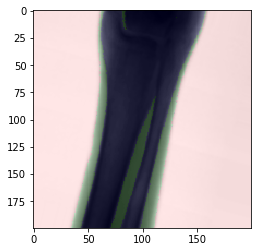

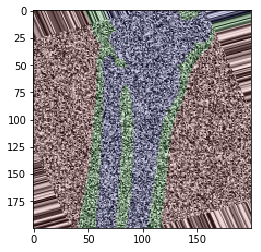

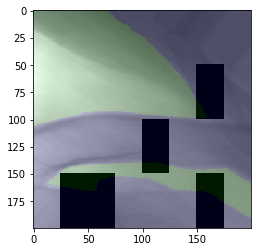

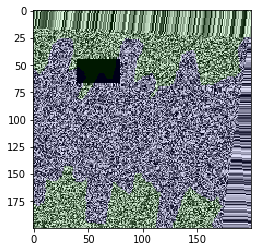

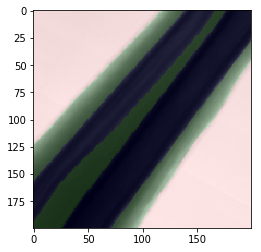

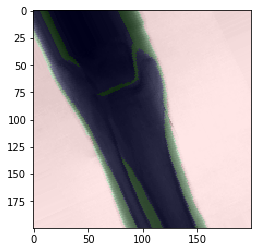

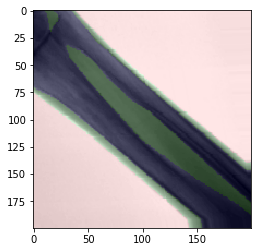

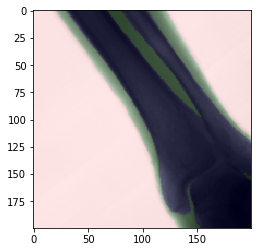

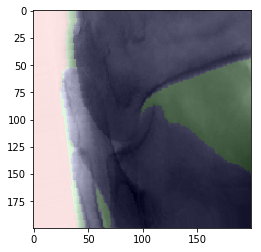

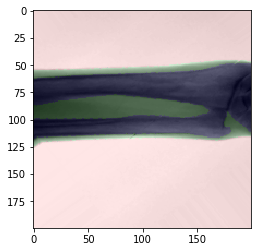

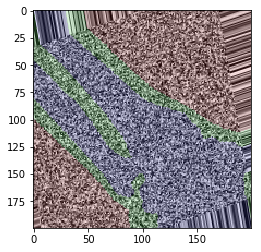

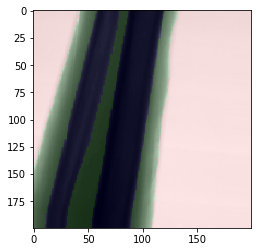

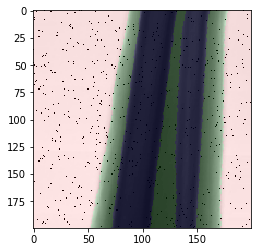

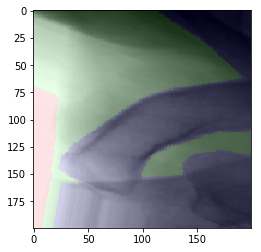

In [59]:
n =  10

for i in range(n):
    plt.imshow(dataset['train_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['train_label'][i,...],alpha=0.1)
    plt.show()
    plt.imshow(dataset['train_img'][i,...,0],cmap='gray')
    plt.show()
    plt.imshow(dataset['train_label'][i,...])
    plt.show()
    
for i in range(n):
    plt.imshow(dataset['val_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['val_label'][i,...],alpha=0.1)
    plt.show()
for i in range(n):
    plt.imshow(dataset['test_img'][i,...,0],cmap='gray')
    plt.imshow(dataset['test_label'][i,...],alpha=0.1)
    plt.show()

# Features

In [171]:

def RandomGaussian(image,sigma=2.):
    ftg = filters.gaussian(image,sigma)
    #return np.reshape(ftg, (image.shape[0]*image.shape[1]*3))
    return ftg

def Laplacian(image):
    ftl = filters.laplace(image)
    #return np.reshape(ftl, (image.shape[0]*image.shape[1]*3))   
    return ftl

def HOG(image,orientations=8, pixels_per_cell=4, cells_per_block=1):
    fd, hog_image = skimage.feature.hog(image, orientations=orientations, pixels_per_cell=(pixels_per_cell, \
                    pixels_per_cell),cells_per_block=(cells_per_block, cells_per_block),visualise=True)
    return fd,hog_image

def canny(image, sigma=2., lthres=None, hthres=None):
    fc = skimage.feature.canny(image, sigma=1.0, low_threshold=None, high_threshold=None,\
                      mask=None, use_quantiles=False)
    return fc

def structure_tensor(image, sigma=2.):
    Axx, Axy, Ayy = skimage.feature.structure_tensor(image, sigma=sigma)
    eig = skimage.feature.structure_tensor_eigvals(Axx, Axy, Ayy)[0]
    return eig

def hessian(image,sigma=2.):
    # RETURNS ALL THE COMPONNETS! keep only last?
    fhess = skimage.feature.hessian_matrix(image, sigma=sigma, mode='constant', cval=0,order='xy')
    return fhess[-1]

def harris(image):
    # DOESN'T LOOK VERY PROMISING
    fharris = skimage.feature.corner_harris(image, method='k', k=0.5, eps=1e-08, sigma=2)
    return fharris

def median(image):
    fmed = skimage.filters.median(image, selem=None, out=None, mask=None, shift_x=False, shift_y=False)
    return fmed

def sobel(image):
    fsob = skimage.filters.sobel(image, mask=None)
    return fsob

def gabor(image):
    # Returns complex and imaginary
    fthres =  skimage.filters.gabor(image, frequency=0.6)
    return fthres

def apply_filters(x,y,images,labels,n_features):
    for i in range(images.shape[0]):
        pixel_init = i*dataset.attrs['image_size']*dataset.attrs['image_size']
        pixel_final = (i+1)*dataset.attrs['image_size']*dataset.attrs['image_size']
        x[pixel_init:pixel_final,0] = images[i,...,0].flatten()
        x[pixel_init:pixel_final,1] = RandomGaussian(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,2] = Laplacian(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,3] = HOG(images[i,...,0])[1].flatten()
        x[pixel_init:pixel_final,4] = canny(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,5] = structure_tensor(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,6] = hessian(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,7] = harris(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,8] = median(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,9] = sobel(images[i,...,0]).flatten()
        x[pixel_init:pixel_final,10] = gabor(images[i,...,0])[0].flatten()
        x[pixel_init:pixel_final,11] = gabor(images[i,...,0])[1].flatten()
        y[pixel_init:pixel_final] = np.argmax(labels[i], axis=2, out=None).flatten()
    return x,y

# Visualize filters

/home/florpi/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


gaussian


/home/florpi/.local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


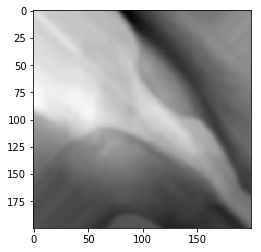

laplacian


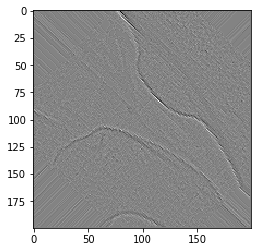

HOG


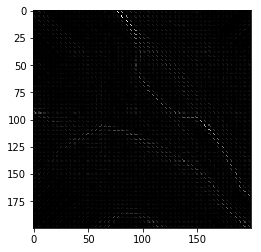

canny


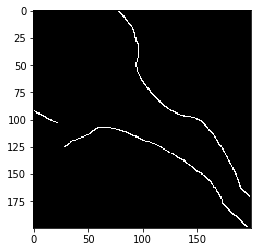

structure_tensor


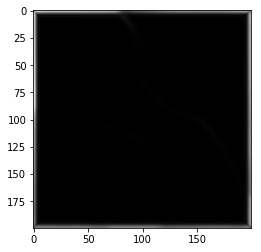

hessian


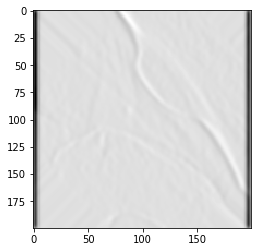

harris_corner


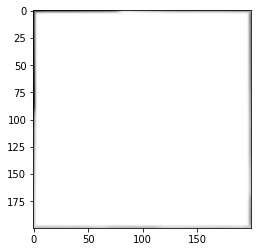

median


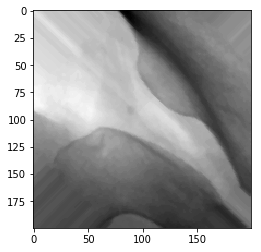

sobel


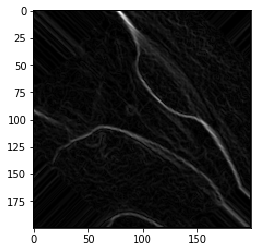

gabor_real


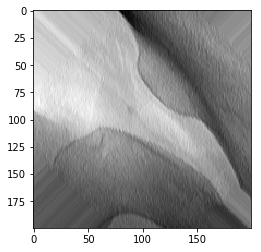

gabor_imaginary


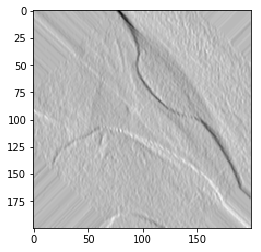

In [38]:
index = 0
visualize_image = dataset['train_img'][index,...,0]
filters_list = [RandomGaussian(visualize_image), Laplacian(visualize_image), HOG(visualize_image)[1],\
           canny(visualize_image), structure_tensor(visualize_image), hessian(visualize_image),\
           harris(visualize_image), median(visualize_image), sobel(visualize_image), gabor(visualize_image)[0],\
           gabor(visualize_image)[1]]
filters_names = ['gaussian','laplacian','HOG','canny','structure_tensor', 'hessian','harris_corner','median',\
                'sobel','gabor_real','gabor_imaginary']

for (i,f) in enumerate(filters_list):
    print(filters_names[i])
    plt.imshow(f,cmap='gray')
    plt.show()


# Create input for random forest

In [173]:
# Input data must has shape [n_samples, n_features]
index = 4

n_features = len(filters_list) 
n_images = dataset['train_img'].shape[0]

x = np.empty((n_images*dataset.attrs['image_size']*dataset.attrs['image_size'], n_features+1))
# +1 for the actual image
y = np.empty((n_images*dataset.attrs['image_size']*dataset.attrs['image_size']))

x, y = apply_filters(x,y,dataset['train_img'], dataset['train_label'],n_features)


/home/florpi/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/florpi/.local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


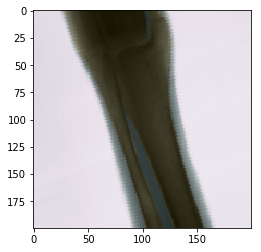

In [181]:
index_show = 203
plt.imshow(np.reshape(x[200*200*index_show:200*200*(index_show+1),0],(200,200)),cmap='gray')
plt.imshow(np.reshape(y[200*200*index_show:200*200*(index_show+1)],(200,200)),alpha=0.1)


In [183]:
n_test= dataset['test_img'].shape[0]

test_x = np.empty((n_test*dataset.attrs['image_size']*dataset.attrs['image_size'], n_features+1))
test_y = np.empty((n_test*dataset.attrs['image_size']*dataset.attrs['image_size']))
test_x, test_y = apply_filters(test_x,test_y,dataset['test_img'], dataset['test_label'],n_features)

/home/florpi/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/florpi/.local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


# Train a random forest classifier

In [ ]:
RF = RandomForestClassifier(verbose=1)

RF.fit(x,y)

In [ ]:
train_accuracy = RF.score(x,y)

In [ ]:
test_accuracy = RF.score(test_x,test_y)

In [ ]:
print('Training acuracy :  %f' %train_accuracy)
print('Test acuracy :  %f' %test_accuracy)

In [149]:
prediction = RF.predict(pred_x)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


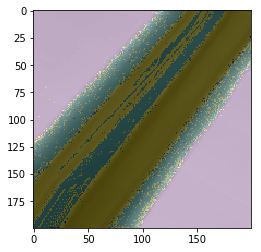

In [150]:
plt.imshow(np.reshape(pred_x[:,0],(200,200)),cmap='gray')
plt.imshow(np.reshape(prediction,(200,200)),alpha=0.3)